<a href="https://colab.research.google.com/github/DipanSardar/cnn_im/blob/main/210130_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf cnn_im
!git clone https://github.com/DipanSardar/cnn_im.git
!ls -la cnn_im


Cloning into 'cnn_im'...
remote: Enumerating objects: 3271, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3271 (delta 0), reused 0 (delta 0), pack-reused 3268 (from 2)
Receiving objects: 100% (3271/3271), 111.97 MiB | 15.16 MiB/s, done.
total 28
drwxr-xr-x 5 root root 4096 Dec 25 20:56 .
drwxr-xr-x 1 root root 4096 Dec 25 20:55 ..
drwxr-xr-x 2 root root 4096 Dec 25 20:56 custom_image
drwxr-xr-x 5 root root 4096 Dec 25 20:56 dataset
drwxr-xr-x 8 root root 4096 Dec 25 20:56 .git
-rw-r--r-- 1 root root 4701 Dec 25 20:56 README.md


In [ ]:
!pip -q install scikit-learn

import os, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
ROOT = Path("/content/cnn_im")
DATASET_DIR = ROOT / "dataset"          # ✅ repo shows "dataset"
TRAIN_DIR = DATASET_DIR / "train"
TEST_DIR  = DATASET_DIR / "test"

CUSTOM_DIR = ROOT / "custom_image"      # ✅ repo shows "custom_image"

print("Train:", TRAIN_DIR)
print("Test :", TEST_DIR)
print("Custom:", CUSTOM_DIR)
print("Custom images:", len(list(CUSTOM_DIR.glob("*"))))


Train: /content/cnn_im/dataset/train
Test : /content/cnn_im/dataset/test
Custom: /content/cnn_im/custom_image
Custom images: 10


In [ ]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def list_dirs(d: Path):
    return sorted([p for p in d.iterdir() if p.is_dir()])

# canonical lowercase class list from TRAIN
train_folders = list_dirs(TRAIN_DIR)
class_names = sorted({p.name.lower() for p in train_folders})
class_to_idx = {c:i for i, c in enumerate(class_names)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

print("Classes:", class_names)
print("Num classes:", len(class_names))


Classes: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Num classes: 10


In [ ]:
def scan_split(split_dir: Path, class_to_idx: dict):
    records = []
    for cls_folder in list_dirs(split_dir):
        cls_key = cls_folder.name.lower()
        if cls_key not in class_to_idx:
            continue
        y = class_to_idx[cls_key]
        for fp in cls_folder.iterdir():
            if fp.is_file() and fp.suffix.lower() in IMG_EXTS:
                records.append((fp, y))
    return records

train_records = scan_split(TRAIN_DIR, class_to_idx)
test_records  = scan_split(TEST_DIR, class_to_idx)

print("Train images:", len(train_records))
print("Test images :", len(test_records))


Train images: 2301
Test images : 922


In [ ]:
IMG_SIZE = 160
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.72, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=8, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.10),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])


In [ ]:
class FruitDataset(Dataset):
    def __init__(self, records, transform=None):
        self.records = records
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        path, y = self.records[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y, str(path)


In [ ]:
BATCH_SIZE = 32   # ✅ assignment batch_size requirement

rng = np.random.default_rng(SEED)
idx = np.arange(len(train_records))
rng.shuffle(idx)

val_size = int(0.15 * len(train_records))
val_idx = idx[:val_size]
tr_idx  = idx[val_size:]

train_set = FruitDataset([train_records[i] for i in tr_idx], transform=train_tf)
val_set   = FruitDataset([train_records[i] for i in val_idx], transform=test_tf)
test_set  = FruitDataset(test_records, transform=test_tf)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


Train: 1956 Val: 345 Test: 922


In [ ]:
class SimpleFruitCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 96, 3, padding=1), nn.BatchNorm2d(96), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(96, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.30),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

model = SimpleFruitCNN(len(class_names)).to(device)
model


SimpleFruitCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
EPOCHS = 15
LR = 1e-3

criterion = nn.CrossEntropyLoss(label_smoothing=0.03)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=2e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)


In [ ]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()

    total_loss, total_correct, total = 0.0, 0, 0

    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss/total, 100.0*total_correct/total


train_loss, train_acc = [], []
val_loss, val_acc = [], []

best_val = -1
best_state = None

for ep in range(1, EPOCHS+1):
    tl, ta = run_epoch(train_loader, train=True)
    vl, va = run_epoch(val_loader, train=False)
    scheduler.step()

    train_loss.append(tl); train_acc.append(ta)
    val_loss.append(vl);   val_acc.append(va)

    if va > best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep:02d}/{EPOCHS} | "
          f"Train Loss {tl:.4f} Acc {ta:.2f}% | "
          f"Val Loss {vl:.4f} Acc {va:.2f}% | "
          f"LR {optimizer.param_groups[0]['lr']:.6f}")

model.load_state_dict(best_state)
model.to(device)
print("Best Val Accuracy:", best_val)


Epoch 01/15 | Train Loss 1.8228 Acc 40.34% | Val Loss 1.6614 Acc 44.35% | LR 0.001000
Epoch 02/15 | Train Loss 1.5613 Acc 50.31% | Val Loss 1.4687 Acc 52.75% | LR 0.001000
Epoch 03/15 | Train Loss 1.4640 Acc 54.35% | Val Loss 1.3874 Acc 57.10% | LR 0.001000
Epoch 04/15 | Train Loss 1.4474 Acc 53.58% | Val Loss 1.3385 Acc 59.42% | LR 0.001000
Epoch 05/15 | Train Loss 1.3453 Acc 57.92% | Val Loss 1.3382 Acc 57.39% | LR 0.001000
Epoch 06/15 | Train Loss 1.2891 Acc 59.82% | Val Loss 1.3991 Acc 53.91% | LR 0.000500
Epoch 07/15 | Train Loss 1.2160 Acc 62.42% | Val Loss 1.2826 Acc 61.45% | LR 0.000500
Epoch 08/15 | Train Loss 1.2194 Acc 63.19% | Val Loss 1.2744 Acc 60.29% | LR 0.000500
Epoch 09/15 | Train Loss 1.2072 Acc 63.60% | Val Loss 1.1510 Acc 66.96% | LR 0.000500
Epoch 10/15 | Train Loss 1.1673 Acc 64.88% | Val Loss 1.1590 Acc 65.80% | LR 0.000500
Epoch 11/15 | Train Loss 1.1760 Acc 64.31% | Val Loss 1.1854 Acc 62.03% | LR 0.000500
Epoch 12/15 | Train Loss 1.1291 Acc 65.08% | Val Loss 

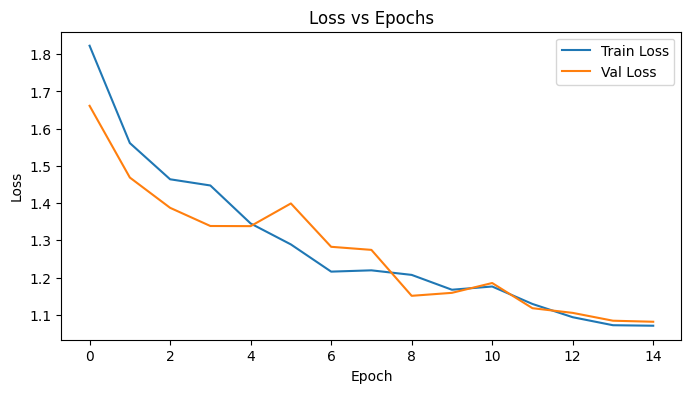

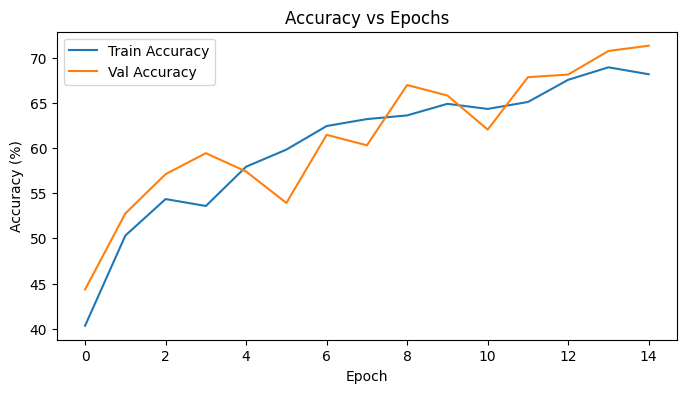

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


TEST Accuracy: 67.25%


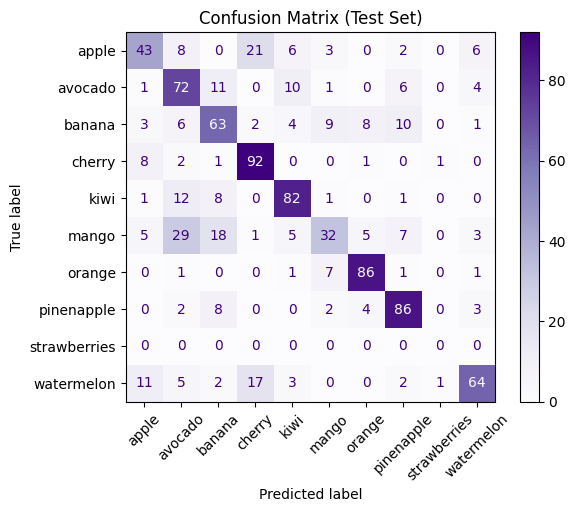

In [ ]:
model.eval()
preds_all, true_all = [], []

with torch.no_grad():
    for x, y, _ in test_loader:
        logits = model(x.to(device))
        preds = logits.argmax(1).cpu().numpy()
        preds_all.extend(preds)
        true_all.extend(y.numpy())

preds_all = np.array(preds_all)
true_all  = np.array(true_all)

test_accuracy = 100.0 * (preds_all == true_all).mean()
print(f"TEST Accuracy: {test_accuracy:.2f}%")

cm = confusion_matrix(true_all, preds_all)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Purples", xticks_rotation=45, values_format="d")  # <- change cmap
plt.title("Confusion Matrix (Test Set)")
plt.show()


Collected: 10 correct, 3 incorrect


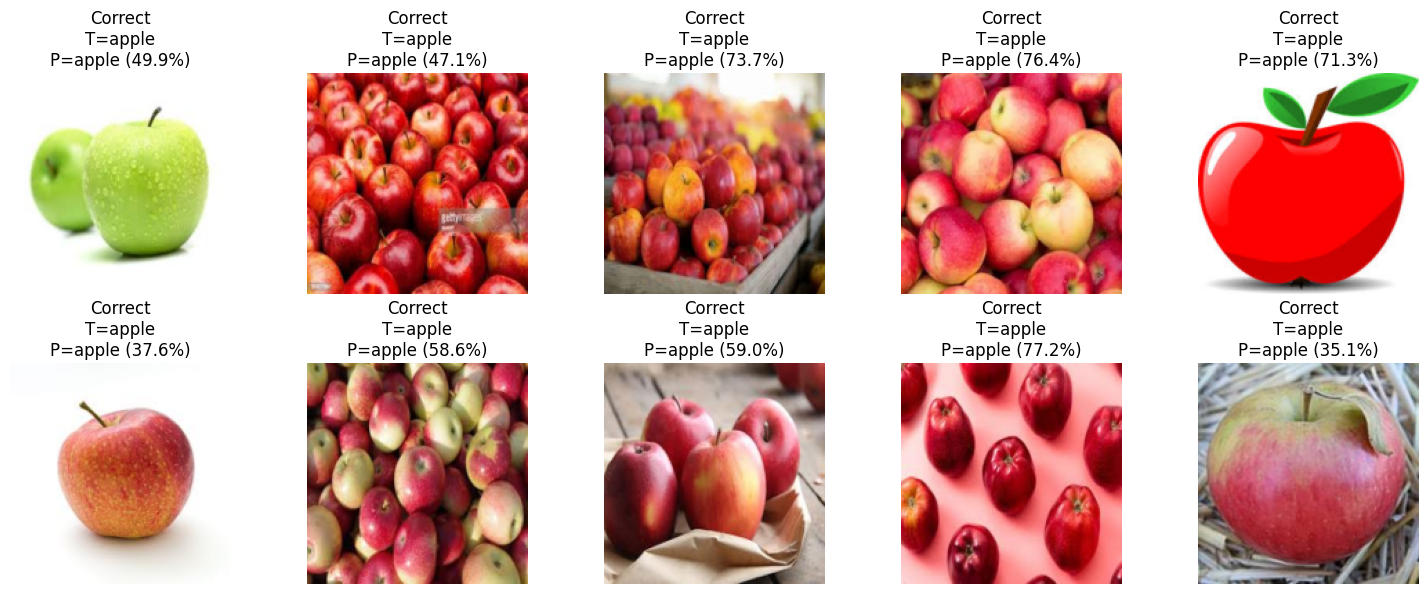

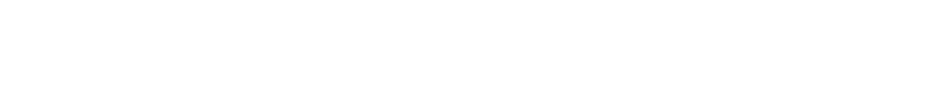

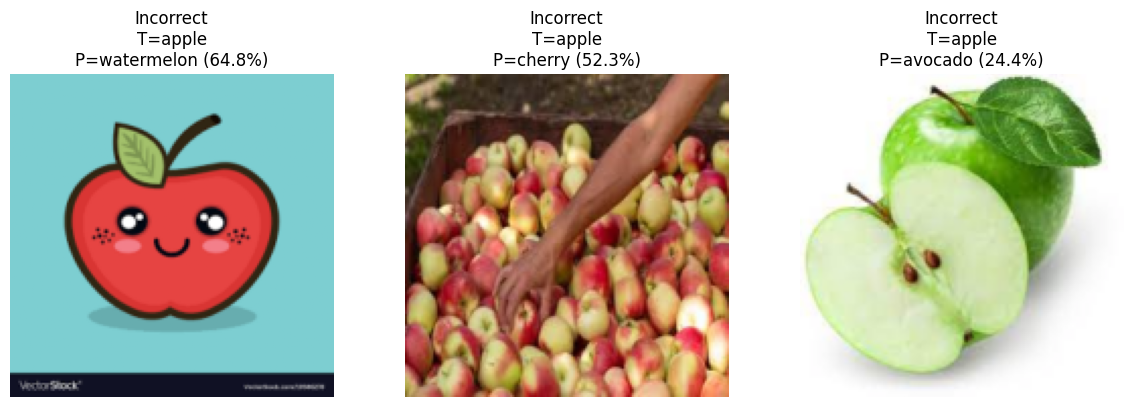

In [ ]:
def unnormalize(img_t):
    x = img_t.clone()
    for c in range(3):
        x[c] = x[c] * STD[c] + MEAN[c]
    return torch.clamp(x, 0, 1)

def show_tensor(img_t):
    img = unnormalize(img_t).permute(1,2,0).numpy()
    plt.imshow(img); plt.axis("off")

correct_examples, incorrect_examples = [], []

model.eval()
with torch.no_grad():
    for images, labels, paths in test_loader:
        out = model(images.to(device))
        probs = torch.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)

        for i in range(images.size(0)):
            t = int(labels[i])
            p = int(preds[i])
            conf = float(probs[i, p])

            if t == p and len(correct_examples) < 10:
                correct_examples.append((images[i].cpu(), t, p, conf))
            elif t != p and len(incorrect_examples) < 3:
                incorrect_examples.append((images[i].cpu(), t, p, conf))

            if len(correct_examples) >= 10 and len(incorrect_examples) >= 3:
                break
        if len(correct_examples) >= 10 and len(incorrect_examples) >= 3:
            break

print("Collected:", len(correct_examples), "correct,", len(incorrect_examples), "incorrect")

# 10 correct
plt.figure(figsize=(15,6))
for k, (img, t, p, conf) in enumerate(correct_examples):
    plt.subplot(2,5,k+1)
    show_tensor(img)
    plt.title(f"Correct\nT={idx_to_class[t]}\nP={idx_to_class[p]} ({conf*100:.1f}%)")
plt.tight_layout()
plt.show()

# space
plt.figure(figsize=(12,1)); plt.axis("off"); plt.show()

# 3 incorrect
plt.figure(figsize=(12,4))
for k, (img, t, p, conf) in enumerate(incorrect_examples):
    plt.subplot(1,3,k+1)
    show_tensor(img)
    plt.title(f"Incorrect\nT={idx_to_class[t]}\nP={idx_to_class[p]} ({conf*100:.1f}%)")
plt.tight_layout()
plt.show()


Custom files: ['apple.jpg', 'avocado.jpg', 'banana.jpg', 'cherry.jpg', 'kiwi.jpg', 'mango.jpg', 'orange.jpg', 'pineapple.jpg', 'strawberry.jpg', 'watermelon.jpg']


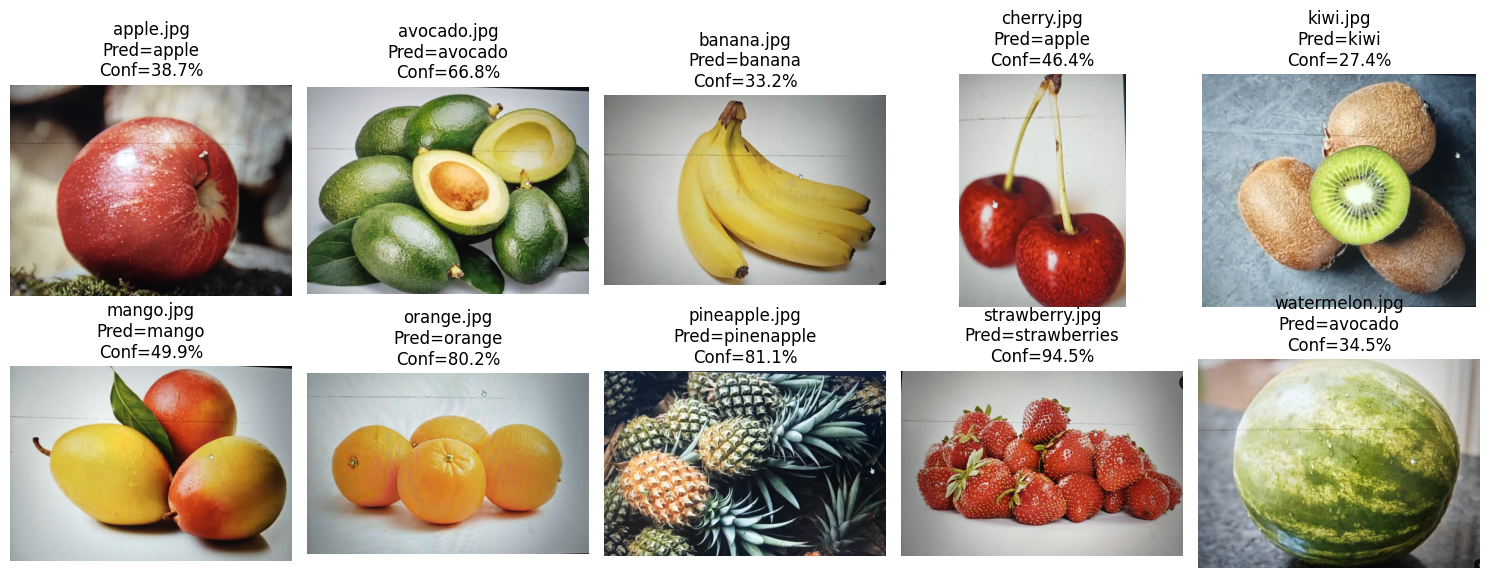

In [ ]:
custom_files = sorted([p for p in CUSTOM_DIR.iterdir() if p.suffix.lower() in IMG_EXTS])[:10]
print("Custom files:", [p.name for p in custom_files])

model.eval()
plt.figure(figsize=(15,6))

for i, fp in enumerate(custom_files):
    img = Image.open(fp).convert("RGB")
    x = test_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        pr = torch.softmax(out, dim=1)[0].cpu().numpy()
        pred = int(np.argmax(pr))
        conf = float(pr[pred])

    plt.subplot(2,5,i+1)
    plt.imshow(img); plt.axis("off")
    plt.title(f"{fp.name}\nPred={idx_to_class[pred]}\nConf={conf*100:.1f}%")

plt.tight_layout()
plt.show()


In [ ]:
SAVE_DIR = ROOT / "model"
SAVE_DIR.mkdir(exist_ok=True)

STUDENT_ID = "DIPAN"   # <- student should set their own ID
save_path = SAVE_DIR / f"{STUDENT_ID}.pth"

torch.save(model.state_dict(), save_path)
print("Saved model to:", save_path)


Saved model to: /content/cnn_im/model/DIPAN.pth
